#Data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.init
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings('ignore')

In [26]:
# Image to Tensor
transform = transforms.ToTensor()

In [27]:
train = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test = datasets.MNIST(root='../data',train=False, download=True, transform=transform)

In [28]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [29]:
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [30]:
image, label = train[0]
print(f'Image\'s shape : {image.shape}')

Image's shape : torch.Size([1, 28, 28])


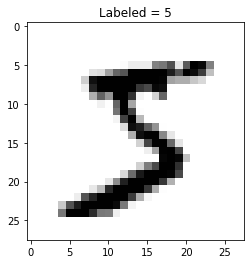

In [31]:
plt.title('Labeled = 5')
plt.imshow(image.reshape(28,28),cmap='gist_yarg')
plt.show()

In [32]:
# Permutation for trian data
train_images = torch.empty(60000,1,28,28)
train_labels = list(range(60000))
for i in range(60000):
    im, l = train[i]
    t = im[0]
    train_images[i][0] = t[torch.randperm(t.size(0))]
    train_labels[i] = train[i][1]

# Permutation for test data
test_images = torch.empty(10000,1,28,28)
test_labels = list(range(10000))
for i in range(10000):
    im, l = test[i]
    t = im[0]
    test_images[i][0] = t[torch.randperm(t.size(0))]
    test_labels[i] = test[i][1]

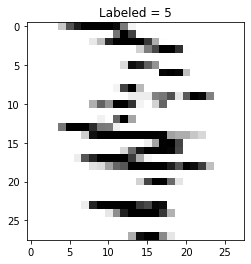

In [33]:
#확인
plt.title(f'Labeled = {train_labels[0]}')
plt.imshow(train_images[0].reshape(28,28),cmap='gist_yarg')
plt.show()

In [34]:
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

train_data = TensorDataset(train_images, train_labels)
test_data = TensorDataset(test_images, test_labels)

# Model

In [35]:
#GPU 사용
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [36]:
# 랜덤시드 고정!
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [37]:
# 학습파라미터 설정
learning_rate = 0.001
training_epochs = 30
batch_size = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

## CNN

In [38]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(60000, 28, 28, 1)
        #    Conv     -> (60000, 28, 28, 32)
        #    Pool     -> (60000, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(60000, 14, 14, 32)
        #    Conv      ->(60000, 14, 14, 64)
        #    Pool      ->(60000, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [39]:
# 모델 정의
model = CNN().to(device)

# 비용함수와 옵티마이저 정의
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(train_loader)
print(f'총 배치의 수 : {total_batch}')

총 배치의 수 : 600


In [40]:
# 훈련
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # 이미지가 이미 (28x28)로 되어있으므로, no reshape
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    if epoch % 4 == 0:
        print(f'[Epoch: {epoch+1:>4}] cost = {avg_cost:>.9}')

[Epoch:    1] cost = 1.34375799
[Epoch:    5] cost = 0.737468064
[Epoch:    9] cost = 0.591634035
[Epoch:   13] cost = 0.510418057
[Epoch:   17] cost = 0.45524317
[Epoch:   21] cost = 0.41242227
[Epoch:   25] cost = 0.379807025
[Epoch:   29] cost = 0.348248094


In [41]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = test_images.view(len(test_images), 1, 28, 28).float().to(device)
    Y_test = test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.7806999683380127


In [50]:
# 좀더 깊은 CNN
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(60000, 28, 28, 1)
        #    Conv     -> (60000, 28, 28, 32)
        #    Pool     -> (60000, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(60000, 14, 14, 32)
        #    Conv      ->(60000, 14, 14, 64)
        #    Pool      ->(60000, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(60000, 7, 7, 64)
        #    Conv      ->(60000, 7, 7, 128)
        #    Pool      ->(60000, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [51]:
# CNN 모델 정의
model2 = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)   
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

total_batch2 = len(train_loader)
print(f'총 배치의 수 : {total_batch2}')

총 배치의 수 : 600


In [52]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model2(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch2
    if epoch %2 == 0:
        print(f'[Epoch: {epoch+1:>4}] cost = {avg_cost:>.9}')

[Epoch:    1] cost = 1.25601411
[Epoch:    3] cost = 0.675678611
[Epoch:    5] cost = 0.526547432
[Epoch:    7] cost = 0.435393244
[Epoch:    9] cost = 0.370667309
[Epoch:   11] cost = 0.303283662
[Epoch:   13] cost = 0.260017604
[Epoch:   15] cost = 0.215765312
[Epoch:   17] cost = 0.191064447
[Epoch:   19] cost = 0.15756163
[Epoch:   21] cost = 0.139478892
[Epoch:   23] cost = 0.125281736
[Epoch:   25] cost = 0.1131979
[Epoch:   27] cost = 0.107607014
[Epoch:   29] cost = 0.0972167775


In [53]:
with torch.no_grad():
    X_test = test_images.view(len(test_images), 1, 28, 28).float().to(device)
    Y_test = test_labels.to(device)

    prediction = model2(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.8235999941825867


In [54]:
import random
random.seed(777)

Label:  9
Prediction:  9


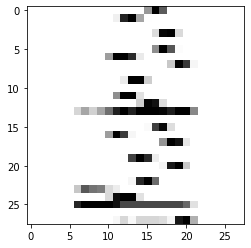

In [58]:
# 예측
with torch.no_grad():
    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(test_labels) - 1)
    X_single_data = test_images[r].view(1,1,28, 28).float().to(device)
    Y_single_data = test_labels[r].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model2(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(test_images[0].view(28, 28), cmap='Greys')
    plt.show()